In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.special import inv_boxcox       # to use absolute value
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Read cleanest data
data = pd.read_csv('fifa21_male2-post-exploration.csv', index_col='ID')

# Remove name & club columns, as they would not help the model
data.drop(['name', 'club'], axis=1, inplace=True)

In [ ]:
def corr_destroyer(data, target, max_threshold=0.95):
    corr_data = data.corr()
    corr_target = corr_data[target]
    corr_data.drop(target, axis=1, inplace=True)
    corr_data.drop(target, axis=0, inplace=True)
    
    column_no = corr_data.shape[0]
    to_drop = []

    for i in range(0, column_no):
        for j in range(i + 1, column_no):
            if corr_data.iloc[i, j] > max_threshold:
                if corr_target.iloc[i] > corr_target.iloc[j]:
                    to_drop.append(corr_data.columns[j])
                else:                 
                    to_drop.append(corr_data.columns[i])
    
    to_drop = list(set(to_drop)) # Get unique values
    return to_drop

### 3. Modelling & Evaluation

#### 3.1. Define scaling, normalizing & encoding functions


##### 3.1.1. Data Scaling

In [ ]:
def normalize_data(df):
    num = df.select_dtypes(np.number)
    transformer = MinMaxScaler().fit(num) 
    x_minmax = transformer.transform(num)
    num_norm = pd.DataFrame(x_minmax, columns=num.columns, index=num.index)
    return num_norm

##### 3.1.2. Box-Cox transformation

In [ ]:
def boxcox_transform(data):
    numeric_cols = data.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        if len(data[column].unique()) < 100:
            continue
        else:
            # since i know any columns should take negative numbers, to avoid -inf in df
            data[column] = np.where(data[column]<=0, np.NAN, data[column]) 
            data[column] = data[column].fillna(data[column].median())
            transformed_data, ci = stats.boxcox(data[column])
            data[column] = transformed_data
            _ci[column] = [ci] 
    return data, _ci

##### 3.1.3. Remove outliers

In [ ]:
def remove_outliers(df, threshold=1.5):
    numerical = df.select_dtypes(np.number)
    columns = numerical.columns
    for column in columns:
        if len(df[column].unique()) < 100:
            continue
        else:
            upper = np.percentile(df[column], 75)
            lower = np.percentile(df[column], 25)
            iqr = upper - lower
            upper_limit = upper + threshold * iqr
            lower_limit = lower - threshold * iqr
            df = df[(df[column]>lower_limit) & (df[column]<upper_limit)]
    return df

##### 3.1.5. Encode categorical data (`get_dummies`)

In [ ]:
def encode_cat(df):
    cat = df.select_dtypes(object)
    cat = pd.get_dummies(cat, columns=cat.columns, drop_first=True)
    return cat

##### 3.1.6. Concatenate numerical and categorical data

In [ ]:
def new_df(num, cat):
    new_df = pd.concat([num, cat], axis=1)
    return new_df

#### 3.2. Define evaluating functions

##### 3.2.1. Running linear regression model

In [ ]:
def regression(df, target):
    y = df[target]
    X = df.drop(target, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    return r2, predictions, y_test

##### 3.2.2. Reversing Box-Cox transformation on predictions & real data



In [ ]:
def reversing(predictions, _ci, target):
    try:                              # in case the target wasn't transformed
      predictions = inv_boxcox(predictions, _ci[target][0])
    except:
      print('The target wasn\'t transformed')
    return predictions

##### 3.2.3. Create dataframe analyzing the differences between real & predicted values

In [ ]:
def diff_df(y_test, _ci, target, predictions):
    results = pd.DataFrame()
    results['true'] = reversing(y_test, _ci, target)
    results['pred'] = reversing(predictions, _ci, target)
    results['diff'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
    results = results.sort_values('diff', ascending=False).head(20)
    return results

##### 3.2.4. Calculate RMSE, MSE, and MAE on reversed data

In [ ]:
def evaluate_model_2(y_test, predictions):                                        
    RMSE = mean_squared_error(y_test, predictions, squared=False)
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    return print("RMSE =", RMSE), print("MSE =", MSE), print("MAE =", MAE)

##### 3.2.5. Plot results

In [ ]:
def we_like_to_see(results):
    beautiful_graph = sns.regplot(results['true'], results['pred'])
    return beautiful_graph

#### 3.3. Optimize model for the `overall_score`

##### 3.3.1. Use all of the transformations:

In [ ]:
# Create dataframe copy
data_1 = data.copy()

# Remove correlated data
to_drop = corr_destroyer(data_1, target='overall_score')
data_1.drop(to_drop, axis=1, inplace=True)

0.9999984287018612
The target wasn't transformed
RMSE = 0.00018571655497860316
MSE = 3.4490638793120536e-08
MAE = 4.8728944057285046e-06
The target wasn't transformed
The target wasn't transformed


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


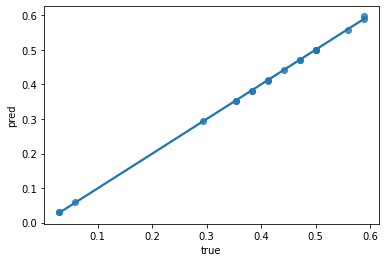

In [ ]:
# 1. Remove outliers
data_1 = remove_outliers(data_1)

# 2. Box-Cox transform
data_1, _ci_1 = boxcox_transform(data_1)

# 3. Scale numerical data
num_norm_1 = normalize_data(data_1)

# 4. Encode categorical data
cat_1 = encode_cat(data_1)

# 5. Merge numerical & categorical data
new_df_1 = new_df(num_norm_1, cat_1)

# 6. Run regression
r2_1, predictions_1, y_test_1 = regression(new_df_1, 'overall_score')
print(r2_1)

# 7. See the predictions
predictions_1 = reversing(predictions_1, _ci=_ci_1, target='overall_score')
evaluate_model_2(y_test_1, predictions_1)
results = diff_df(y_test_1, _ci_1, target='overall_score', predictions=predictions_1)
we_like_to_see(results)

##### 3.3.2. Use everything but corr_destroyer:

In [ ]:
# Create dataframe copy
data_1 = data.copy()

# Remove correlated data
#to_drop = corr_destroyer(data_1, target='overall_score')
#data_1.drop(to_drop, axis=1, inplace=True)

0.9999854211986992
The target wasn't transformed
RMSE = 0.0006230795321679564
MSE = 3.882281034066395e-07
MAE = 1.8100393657776552e-05
The target wasn't transformed
The target wasn't transformed


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


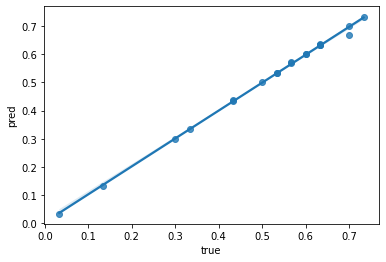

In [ ]:
# 1. Remove outliers
data_1 = remove_outliers(data_1)

# 2. Box-Cox transform
data_1, _ci_1 = boxcox_transform(data_1)

# 3. Scale numerical data
num_norm_1 = normalize_data(data_1)

# 4. Encode categorical data
cat_1 = encode_cat(data_1)

# 5. Merge numerical & categorical data
new_df_1 = new_df(num_norm_1, cat_1)

# 6. Run regression
r2_1, predictions_1, y_test_1 = regression(new_df_1, 'overall_score')
print(r2_1)

# 7. See the predictions
predictions_1 = reversing(predictions_1, _ci=_ci_1, target='overall_score')
evaluate_model_2(y_test_1, predictions_1)
results = diff_df(y_test_1, _ci_1, target='overall_score', predictions=predictions_1)
we_like_to_see(results)

##### 3.3.3. Use everything but remove_outliers:

In [ ]:
# Create dataframe copy
data_1 = data.copy()

# Remove correlated data
to_drop = corr_destroyer(data_1, target='overall_score')
data_1.drop(to_drop, axis=1, inplace=True)

0.9999995608843807
The target wasn't transformed
RMSE = 9.419556743944621e-05
MSE = 8.872804925239258e-09
MAE = 3.1252033112383055e-06
The target wasn't transformed
The target wasn't transformed


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


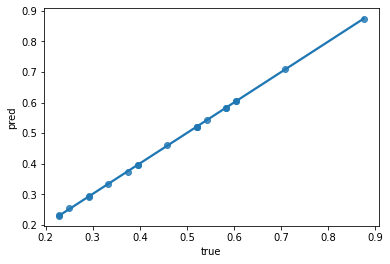

In [ ]:
# 1. Remove outliers
#data_1 = remove_outliers(data_1)

# 2. Box-Cox transform
data_1, _ci_1 = boxcox_transform(data_1)

# 3. Scale numerical data
num_norm_1 = normalize_data(data_1)

# 4. Encode categorical data
cat_1 = encode_cat(data_1)

# 5. Merge numerical & categorical data
new_df_1 = new_df(num_norm_1, cat_1)

# 6. Run regression
r2_1, predictions_1, y_test_1 = regression(new_df_1, 'overall_score')
print(r2_1)

# 7. See the predictions
predictions_1 = reversing(predictions_1, _ci=_ci_1, target='overall_score')
evaluate_model_2(y_test_1, predictions_1)
results = diff_df(y_test_1, _ci_1, target='overall_score', predictions=predictions_1)
we_like_to_see(results)

##### 3.3.4. Use everything but Box-Cox:

In [ ]:
# Create dataframe copy
data_1 = data.copy()

# Remove correlated data
to_drop = corr_destroyer(data_1, target='overall_score')
data_1.drop(to_drop, axis=1, inplace=True)

0.9999999999999887
The target wasn't transformed
RMSE = 1.5791532256875433e-08
MSE = 2.4937249101993734e-16
MAE = 3.4886644613229873e-10
The target wasn't transformed
The target wasn't transformed


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


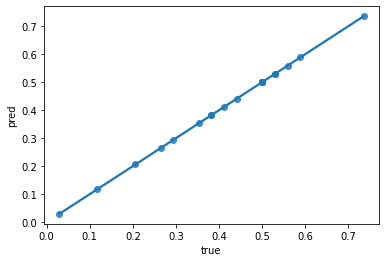

In [ ]:
# 1. Remove outliers
data_1 = remove_outliers(data_1)

# 2. Box-Cox transform
#data_1, _ci_1 = boxcox_transform(data_1)

# 3. Scale numerical data
num_norm_1 = normalize_data(data_1)

# 4. Encode categorical data
cat_1 = encode_cat(data_1)

# 5. Merge numerical & categorical data
new_df_1 = new_df(num_norm_1, cat_1)

# 6. Run regression
r2_1, predictions_1, y_test_1 = regression(new_df_1, 'overall_score')
print(r2_1)

# 7. See the predictions
predictions_1 = reversing(predictions_1, _ci=_ci_1, target='overall_score')
evaluate_model_2(y_test_1, predictions_1)
results = diff_df(y_test_1, _ci_1, target='overall_score', predictions=predictions_1)
we_like_to_see(results)

##### 3.3.5. Use everything but scaling

In [ ]:
# Create dataframe copy
data_1 = data.copy()

# Remove correlated data
to_drop = corr_destroyer(data_1, target='overall_score')
data_1.drop(to_drop, axis=1, inplace=True)

1.0
The target wasn't transformed
RMSE = 7.147825896577388e-11
MSE = 5.109141504778235e-21
MAE = 5.31698339960225e-11
The target wasn't transformed
The target wasn't transformed


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


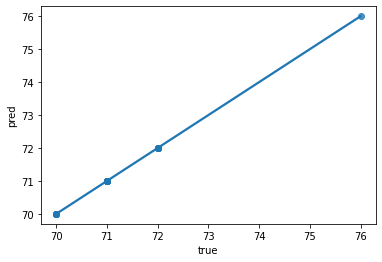

In [ ]:
# 1. Remove outliers
data_1 = remove_outliers(data_1)

# 2. Box-Cox transform
data_1, _ci_1 = boxcox_transform(data_1)

# 3. Scale numerical data
#num_norm_1 = normalize_data(data_1)
num_norm_1 = data_1.select_dtypes(np.number)

# 4. Encode categorical data
cat_1 = encode_cat(data_1)

# 5. Merge numerical & categorical data
new_df_1 = new_df(num_norm_1, cat_1)

# 6. Run regression
r2_1, predictions_1, y_test_1 = regression(new_df_1, 'overall_score')
print(r2_1)

# 7. See the predictions
predictions_1 = reversing(predictions_1, _ci=_ci_1, target='overall_score')
evaluate_model_2(y_test_1, predictions_1)
results = diff_df(y_test_1, _ci_1, target='overall_score', predictions=predictions_1)
we_like_to_see(results)

##### 3.3.6. Use no transformation:

In [ ]:
# Create dataframe copy
data_1 = data.copy()

# Remove correlated data
#to_drop = corr_destroyer(data_1, target='overall_score')
#data_1.drop(to_drop, axis=1, inplace=True)

1.0
The target wasn't transformed
RMSE = 1.5476513044394388e-09
MSE = 2.3952245601330963e-18
MAE = 1.240832995221172e-09
The target wasn't transformed
The target wasn't transformed


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


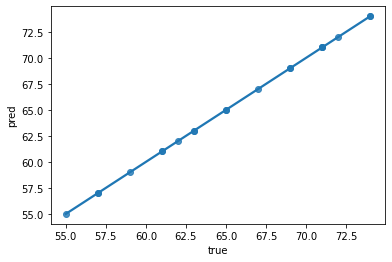

In [ ]:
# 1. Remove outliers
#data_1 = remove_outliers(data_1)

# 2. Box-Cox transform
#data_1, _ci_1 = boxcox_transform(data_1)

# 3. Scale numerical data
#num_norm_1 = normalize_data(data_1)
num_norm_1 = data_1.select_dtypes(np.number)

# 4. Encode categorical data
cat_1 = encode_cat(data_1)

# 5. Merge numerical & categorical data
new_df_1 = new_df(num_norm_1, cat_1)

# 6. Run regression
r2_1, predictions_1, y_test_1 = regression(new_df_1, 'overall_score')
print(r2_1)

# 7. See the predictions
predictions_1 = reversing(predictions_1, _ci=_ci_1, target='overall_score')
evaluate_model_2(y_test_1, predictions_1)
results = diff_df(y_test_1, _ci_1, target='overall_score', predictions=predictions_1)
we_like_to_see(results)

We notice that the transformations have little to no effect on the result of the linear regressions, suggesting that the overall score has been calculated based on the features we selected to begin with. Next steps would be to study other targets in order to see if those would also be as dependent on the features.